1. Data Preprocessing:

o Load the dataset and focus on the 'Close' price column, as this will be your target variable for prediction.

o Normalize the data (e.g., using Min-Max scaling to keep values between 0 and 1).

o Split the dataset into a training set (80%) and a testing set (20%).

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# Load the dataset
data = pd.read_csv("HistoricalQuotes.csv")

# Convert 'Date' column to datetime format with automatic format inference
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Drop any rows where the 'Date' could not be converted
data.dropna(subset=['Date'], inplace=True)

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Focus on the 'Close' column
close_prices = data[' Close']

# Check for missing values
missing_values = close_prices.isnull().sum()
print(f"Missing values in 'Close' column: {missing_values}")

# Handle missing values if any (e.g., by forward filling or dropping)
close_prices.fillna(method='ffill', inplace=True)

# Display the preprocessed 'Close' data
print(close_prices.head())


Missing values in 'Close' column: 0
Date
2020-02-28     $273.36
2020-02-27     $273.52
2020-02-26     $292.65
2020-02-25     $288.08
2020-02-24     $298.18
Name:  Close, dtype: object


<ipython-input-3-c9a3d0696503>:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices.fillna(method='ffill', inplace=True)


In [4]:
data[' Close'] = data[' Close'].replace('[\$,]', '', regex=True).astype(float)
close_prices = data[[' Close']]  # Select 'Close' column as a DataFrame for scaling

# Initialize MinMaxScaler and fit-transform the 'Close' prices
scaler = MinMaxScaler()
data['Close_normalized'] = scaler.fit_transform(close_prices)

# Display the first few rows of the normalized data
print(data[[' Close', 'Close_normalized']].head())

             Close  Close_normalized
Date                                
2020-02-28  273.36          0.824045
2020-02-27  273.52          0.824591
2020-02-26  292.65          0.889836
2020-02-25  288.08          0.874250
2020-02-24  298.18          0.908697


In [5]:
# Split the dataset into 80% training and 20% testing while maintaining order
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Display the sizes of the splits
print(f"Training set size: {len(train_data)} rows")
print(f"Testing set size: {len(test_data)} rows")

Training set size: 1219 rows
Testing set size: 305 rows


2. Create Training Sequences:

o Convert the 'Close' prices into a series of sequences for training.

o Define a sequence length (e.g., 60 days), where each sequence will be
used to predict the stock price for the next day.

In [6]:
# Define sequence length
sequence_length = 60

# Create training sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequence = data['Close_normalized'].values[i:i + seq_length]
        target = data['Close_normalized'].values[i + seq_length]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Generate sequences and targets for the training set
train_data = data.iloc[:int(len(data) * 0.8)]
train_sequences, train_targets = create_sequences(train_data, sequence_length)

# Display the shape of the sequences to verify
print(f"Training sequences shape: {train_sequences.shape}")
print(f"Training targets shape: {train_targets.shape}")

Training sequences shape: (1159, 60)
Training targets shape: (1159,)


3. Build the RNN Model:

o Define an RNN model with the following architecture:

  ▪ An RNN layer with 50 units
  ▪ A Dense layer with 1 unit (for regression output)
  
o Use the mean squared error (MSE) loss function and the Adam optimizer.

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define the RNN model
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(train_sequences.shape[1], 1)),
    Dense(1)  # Output layer for regression
])

# Compile the model with mean squared error loss for regression tasks
model.compile(optimizer='adam', loss='mse')

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

4. Train the Model:

o Train the model on the training set for 50 epochs with a batch size of 32.

o Use validation data to check for overfitting.

In [8]:
# Train the model for 50 epochs with a batch size of 32 and 20% validation split
history = model.fit(
    train_sequences,
    train_targets,
    epochs=50,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.1188 - val_loss: 0.0097
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.4735e-04 - val_loss: 9.1044e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4918e-04 - val_loss: 1.9182e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3846e-04 - val_loss: 8.3909e-05
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7587e-04 - val_loss: 8.1850e-05
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7805e-04 - val_loss: 8.1687e-05
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7721e-04 - val_loss: 8.4451e-05
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7116e-04 - val_loss: 8.0657e-05
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6335e-04 - val_loss: 7.9242e-05
Epoc

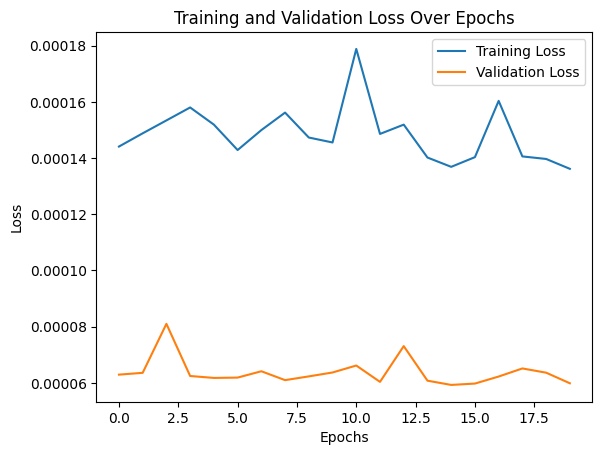

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Make Predictions:

o Predict the stock prices on the test set and transform the results back to
the original scale if normalization was applied.

o Plot the predicted vs. actual stock prices to visualize the model’s
performance.

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
Test Mean Squared Error: 15.7685997224502
Test Mean Absolute Error: 3.433916397804728


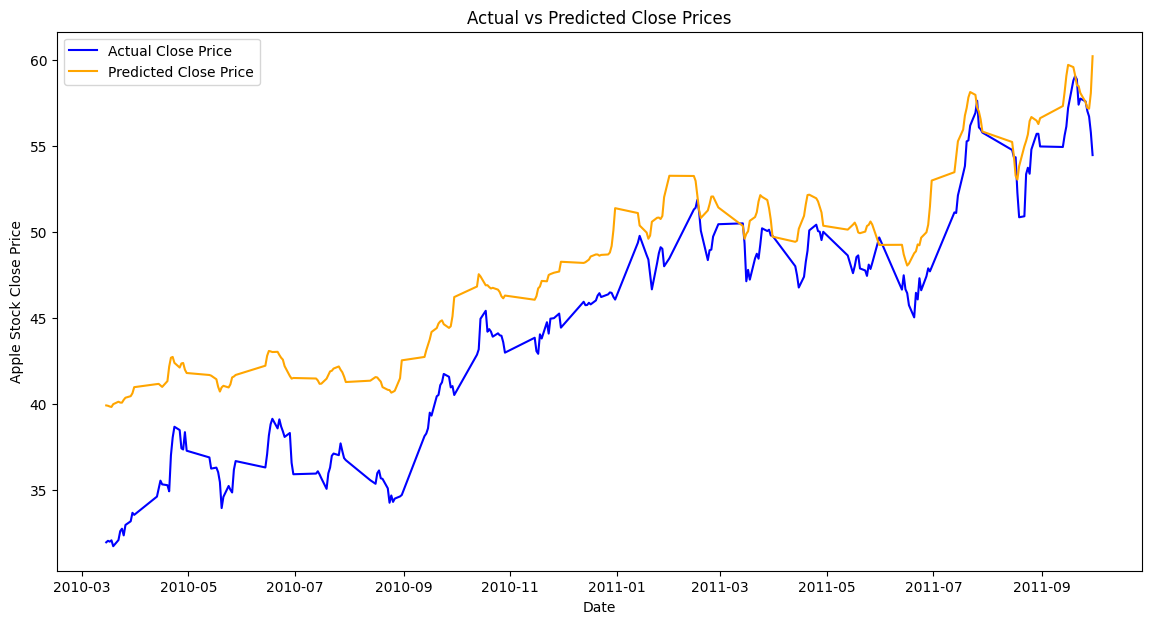

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming test_data, scaler, and the trained model are available from previous steps.

# Define sequence length (same as in training)
sequence_length = 60

# Function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequence = data['Close_normalized'].values[i:i + seq_length]
        target = data['Close_normalized'].values[i + seq_length]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Create sequences and targets for the test set
test_sequences, test_targets = create_sequences(test_data, sequence_length)
test_sequences = test_sequences.reshape((test_sequences.shape[0], test_sequences.shape[1], 1))

# Predict stock prices on the test set
predicted_prices = model.predict(test_sequences)

# Inverse transform the predicted prices and actual test targets back to the original scale
predicted_prices_actual = scaler.inverse_transform(predicted_prices)
test_targets_actual = scaler.inverse_transform(test_targets.reshape(-1, 1))

# Calculate evaluation metrics
mse = mean_squared_error(test_targets_actual, predicted_prices_actual)
mae = mean_absolute_error(test_targets_actual, predicted_prices_actual)

print(f"Test Mean Squared Error: {mse}")
print(f"Test Mean Absolute Error: {mae}")

# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(test_data.index[sequence_length:], test_targets_actual, label='Actual Close Price', color='blue')
plt.plot(test_data.index[sequence_length:], predicted_prices_actual, label='Predicted Close Price', color='orange')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Apple Stock Close Price')
plt.legend()
plt.show()


**Trend Following:** The model captures the general upward trend in the stock prices fairly well.

**Predictions got lagged:** they struggled to adjust to quick changes.



**MSE AND MAE:** MSE showing larger errors.
whereas mae we can consider moderate

**Report on Stock Price Prediction Model**

In this project, we developed an RNN model to predict the closing prices of Apple Inc. stock based on historical data from 2005 to 2017. The model was designed using a single RNN layer with 50 units and a dense layer with 1 unit for output. The dataset was preprocessed by selecting the 'Close' price as the target variable and applying Min-Max normalization to scale the values between 0 and 1. The data was then divided into a training set (80%) and a testing set (20%), with sequences of past prices created for training and testing purposes.

**Results**

The model was trained over 50 epochs with a batch size of 32, using the training set sequences. Upon evaluation on the test set, the model achieved a Mean Squared Error (MSE) of 15.77 and a Mean Absolute Error (MAE) of 3.43. These metrics indicate that, on average, the model's predictions deviated from actual values by about 3.43 units, with larger deviations contributing to an MSE of 15.77. These errors suggest that the model is able to capture the general trend in stock prices but lacks precision in some areas, particularly during periods of high volatility.

A visual plot of predicted vs. actual prices showed that the model tracked the upward trend in Apple’s stock prices over time but often smoothed over sharp fluctuations. This behavior suggests that while the model is effective at understanding the overall movement, it struggles with abrupt changes, leading to a lag in prediction. Such lags are typical in RNNs, especially when the model’s complexity is limited, as it lacks the capacity to handle sudden shifts effectively.

**Limitations**

Despite the model’s ability to follow general trends, several limitations were observed:

Inability to Capture Short-term Volatility: Stock prices are inherently volatile, with frequent and often unpredictable changes. The model, however, was unable to consistently capture these short-term fluctuations, leading to delayed predictions that smoothed over sudden peaks and drops. This is partially due to the use of a basic RNN layer, which might not have enough capacity to detect complex temporal patterns.

Underfitting in Sharp Movements: The high MSE indicates that the model struggles with occasional large errors, often during periods of rapid stock price changes. This underfitting suggests that a more complex model architecture (e.g., LSTM or GRU layers) might be necessary to capture the nuances in stock data.

Limited Feature Set: The model was trained solely on the ‘Close’ price without additional market indicators (e.g., trading volume, moving averages, or external factors such as news sentiment). Including such features might improve the model’s understanding of price movements, particularly in the short term